# Concrete and Pavement Crack Detection using CNN

## 1. Check GPU Availability

This cell checks if a CUDA-capable GPU is available for training. Using a GPU significantly speeds up the training process (10-100x faster than CPU).

**Dataset Information:**
- Source: Nigerian Army University Biu, Borno State, Nigeria
- Total Images: 30,000 (15,000 cracked + 15,000 non-cracked)
- Format: RGB JPEG, 227×227 pixels
- Used in this project: 1,000 images per class (due to hardware limitations)

The next cell will display GPU information including model, memory, and CUDA version.

In [ ]:
!nvidia-smi

Sun Nov 23 13:07:31 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 2. Import Required Libraries

**Libraries being imported:**
- **os**: File path operations
- **numpy**: Numerical computations and array operations
- **PIL (Image)**: Image loading and manipulation
- **torch**: PyTorch deep learning framework
- **torch.nn**: Neural network building blocks
- **torch.nn.functional**: Functional interface for neural network operations
- **Dataset, DataLoader, random_split**: Data loading and splitting utilities
- **transforms**: Image preprocessing and augmentation tools

These libraries provide all the necessary functionality for loading images, building the neural network, training, and evaluating the model.

In [ ]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms




## 3. Configure Computing Device (CPU/GPU)

This cell automatically selects the best available computing device:
- **CUDA (GPU)**: If available - provides much faster training
- **CPU**: Fallback option if no GPU is detected

All model computations and tensor operations will be performed on the selected device throughout this notebook.

In [ ]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 4. Mount Google Drive (For Google Colab Users)

This cell mounts your Google Drive to access the dataset stored there.

**Note**: 
- If running on Google Colab, this allows access to files at `/content/drive/`
- If running locally, you can skip or comment out this cell
- Make sure your dataset is uploaded to Google Drive before running this

After mounting, the dataset should be accessible at the path specified in later cells.

In [ ]:
model = CrackCNN().to(device)
print(f"Model initialized and moved to {device}")

Model initialized and moved to cuda


## 5. Define Custom Dataset Class

This `CrackDataset` class handles loading and preprocessing of crack detection images.

**Key Components:**
1. **Initialization (`__init__`)**: 
   - Accepts paths to positive (cracked) and negative (non-cracked) image directories
   - Optionally limits images per class using `max_images_per_class`
   - Applies transformations to images

2. **Data Loading**:
   - Loads positive samples (cracked surfaces) with label = 1
   - Loads negative samples (non-cracked surfaces) with label = 0
   - Applies preprocessing transformations (resize, convert to tensor)

3. **Required Methods**:
   - `__len__()`: Returns total number of samples
   - `__getitem__(idx)`: Returns a single image-label pair

This class ensures efficient batch loading during training.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 6. Load and Prepare the Dataset

**Data Preprocessing Steps:**

1. **Image Transformations**:
   - Resize from 227×227 to 128×128 pixels (reduces computation)
   - Convert to PyTorch tensor
   - Automatically normalizes pixel values to [0, 1] range

2. **Dataset Paths**:
   - Update these paths to match your Google Drive or local directory structure
   - Positive images: Cracked concrete/pavement surfaces
   - Negative images: Non-cracked surfaces

3. **Train-Test Split**:
   - 70% for training (1,400 images)
   - 30% for testing (600 images)
   - Random split ensures unbiased evaluation

4. **DataLoader Configuration**:
   - Batch size: 50 images per batch
   - Shuffle training data for better generalization
   - Don't shuffle test data for consistent evaluation

The next cell will display the number of training and test samples.

In [ ]:
class CrackDataset(Dataset):
    def __init__(self, positive_dir, negative_dir, transform=None, max_images_per_class=None):
        self.data = []
        self.labels = []
        self.transform = transform

        # Load positive (Crack = 1)
        pos_files = [os.path.join(positive_dir, f) for f in os.listdir(positive_dir) if f.endswith('.jpg')]
        if max_images_per_class:
            pos_files = pos_files[:max_images_per_class]
        for path in pos_files:
            img = Image.open(path).convert('RGB')
            if self.transform:
                img = self.transform(img)
            self.data.append(img)
            self.labels.append(1)

        # Load negative (No Crack = 0)
        neg_files = [os.path.join(negative_dir, f) for f in os.listdir(negative_dir) if f.endswith('.jpg')]
        if max_images_per_class:
            neg_files = neg_files[:max_images_per_class]
        for path in neg_files:
            img = Image.open(path).convert('RGB')
            if self.transform:
                img = self.transform(img)
            self.data.append(img)
            self.labels.append(0)

        self.data = torch.stack(self.data)
        self.labels = torch.tensor(self.labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


## 7. Define the CNN Model Architecture

**CrackCNN - Custom Convolutional Neural Network**

This network is specifically designed for binary crack detection.

**Architecture:**

**Convolutional Feature Extraction:**
- **Block 1**: 
  - Conv layer 1: 3→16 channels (kernel=2, padding=1)
  - Conv layer 2: 16→16 channels
  - Batch Normalization (stabilizes training)
  - Max Pooling 2×2 (reduces spatial dimensions)

- **Block 2**:
  - Conv layer 3: 16→32 channels
  - Conv layer 4: 32→32 channels  
  - Batch Normalization
  - Max Pooling 2×2
  - Dropout 20% (prevents overfitting)

**Classification Layers:**
- Fully Connected 1: Dynamic input → 128 neurons
- Dropout 30% (prevents overfitting)
- Fully Connected 2: 128 → 2 (Cracked/Not Cracked)

**Special Feature**: Dynamic calculation of flattened layer size adapts to input dimensions automatically.

In [ ]:
# Transform: resize + normalization
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),           # Converts [0,255] -> [0,1]
])

positive_dir = r"/content/drive/My Drive/ML_PROJECT/Positive_Analysis"
negative_dir = r"/content/drive/My Drive/ML_PROJECT/Negative_Analysis"

# Create dataset
dataset = CrackDataset(positive_dir, negative_dir, transform=transform, max_images_per_class=1000)

# Split into train/test
train_size = int(0.70 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# DataLoaders
batch_size = 50
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")


Train samples: 1400, Test samples: 600


## 8. Initialize and Move Model to Device

This cell creates an instance of the CrackCNN model and moves it to the selected device (GPU or CPU).

**What happens here:**
1. Model is instantiated with all layers and parameters
2. `.to(device)` transfers all model parameters to GPU/CPU
3. This ensures all subsequent computations happen on the correct device

After this cell, the model is ready for training!

In [ ]:
class CrackCNN(nn.Module):
    def __init__(self):
        super(CrackCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=2, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(16, 32, kernel_size=2, padding=1)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=2, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout(0.2)

        # --- dynamically calculate flattened size ---
        dummy_input = torch.zeros(1, 3, 128, 128)  # batch size 1
        dummy_output = self._forward_features(dummy_input)
        flattened_size = dummy_output.view(1, -1).size(1)
        # ------------------------------------------

        self.fc1 = nn.Linear(flattened_size, 128)
        self.dropout2 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 2)

    def _forward_features(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.bn1(x)
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.bn2(x)
        x = self.pool(x)
        x = self.dropout1(x)
        return x

    def forward(self, x):
        x = self._forward_features(x)
        x = torch.flatten(x, 1)  # flatten all except batch dimension
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x


## 9. Define Loss Function and Optimizer

**Training Components:**

1. **Loss Function: CrossEntropyLoss**
   - Perfect for multi-class classification tasks
   - Combines softmax activation and negative log-likelihood loss
   - Automatically handles class probabilities

2. **Optimizer: Adamax**
   - Variant of the Adam optimizer
   - Uses infinity norm instead of L2 norm
   - Provides adaptive learning rates
   - Robust to hyperparameter choices and noisy gradients

These components work together to calculate errors and update model weights during training.

In [ ]:
criterion = nn.CrossEntropyLoss()  # suitable for multi-class classification
optimizer = torch.optim.Adamax(model.parameters())


## 10. First Training Loop (Without Validation Tracking)

**Training Process - 20 Epochs:**

This is a simplified training loop that focuses only on training data.

**What happens each epoch:**
1. Model set to training mode
2. For each batch of 50 images:
   - Move data to device (GPU/CPU)
   - Reset gradients to zero
   - Forward pass: Get predictions
   - Calculate loss: Compare predictions vs actual labels
   - Backward pass: Compute gradients
   - Optimizer step: Update weights
   - Track running loss and accuracy

3. Display epoch results

**Expected outcome**: Training accuracy should reach ~99-100% by epoch 20.

Note: This loop doesn't track validation/test performance - that's done in a later cell.

In [ ]:
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")


Epoch 1/20 - Loss: 0.0019, Accuracy: 0.9993
Epoch 2/20 - Loss: 0.0029, Accuracy: 0.9986
Epoch 3/20 - Loss: 0.0025, Accuracy: 0.9993
Epoch 4/20 - Loss: 0.0007, Accuracy: 1.0000
Epoch 5/20 - Loss: 0.0039, Accuracy: 0.9993
Epoch 6/20 - Loss: 0.0051, Accuracy: 0.9986
Epoch 7/20 - Loss: 0.0042, Accuracy: 0.9986
Epoch 8/20 - Loss: 0.0109, Accuracy: 0.9986
Epoch 9/20 - Loss: 0.0026, Accuracy: 0.9986
Epoch 10/20 - Loss: 0.0103, Accuracy: 0.9979
Epoch 11/20 - Loss: 0.0092, Accuracy: 0.9964
Epoch 12/20 - Loss: 0.0015, Accuracy: 0.9993
Epoch 13/20 - Loss: 0.0012, Accuracy: 1.0000
Epoch 14/20 - Loss: 0.0012, Accuracy: 1.0000
Epoch 15/20 - Loss: 0.0012, Accuracy: 0.9993
Epoch 16/20 - Loss: 0.0005, Accuracy: 1.0000
Epoch 17/20 - Loss: 0.0090, Accuracy: 0.9986
Epoch 18/20 - Loss: 0.0047, Accuracy: 0.9986
Epoch 19/20 - Loss: 0.0147, Accuracy: 0.9971
Epoch 20/20 - Loss: 0.0012, Accuracy: 1.0000


## 11. Evaluate Model on Test Set

**Testing on Unseen Data:**

After training, we evaluate how well the model performs on data it has never seen before.

**Evaluation Process:**
1. Set model to evaluation mode (`model.eval()`)
2. Disable gradient computation (`torch.no_grad()`) - saves memory
3. Process all test batches
4. Calculate predictions
5. Compute test accuracy

**Why is this important?**
- Training accuracy can be misleading (model might memorize)
- Test accuracy shows real-world performance
- Good test accuracy (~98%) indicates the model generalizes well

**Expected Result**: Test Accuracy around 98.33%

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {correct/total:.4f}")


Test Accuracy: 0.9833


## 12. Complete Training Loop with Validation Tracking

**Enhanced Training - 20 Epochs with Test Evaluation:**

This is the main training loop that tracks both training AND test performance.

**What's different from the previous training loop?**
1. After each training epoch, we also evaluate on test data
2. We track 4 metrics per epoch:
   - Training Loss
   - Training Accuracy
   - Test Loss  
   - Test Accuracy

**Training Phase:**
- Model learns from training data
- Weights are updated using backpropagation

**Validation Phase:**
- Model evaluated on test data (no weight updates)
- Gradients disabled for efficiency
- Helps detect overfitting

**Benefits:**
- Monitor model performance in real-time
- Detect overfitting early (if train accuracy >> test accuracy)
- Generate data for visualizations
- Understand learning progression

All metrics are stored in lists for plotting in subsequent cells.

In [ ]:
num_epochs = 20

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    # --- Training ---
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / total
    epoch_train_acc = correct / total
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    # --- Validation / Test ---
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_test_loss = running_val_loss / total_val
    epoch_test_acc = correct_val / total_val
    test_losses.append(epoch_test_loss)
    test_accuracies.append(epoch_test_acc)

    # Print metrics for each epoch
    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}, "
          f"Train Acc: {epoch_train_acc:.4f}, Test Acc: {epoch_test_acc:.4f}")


Epoch 1/20 - Train Loss: 0.0005, Test Loss: 0.0912, Train Acc: 1.0000, Test Acc: 0.9817
Epoch 2/20 - Train Loss: 0.0010, Test Loss: 0.0926, Train Acc: 1.0000, Test Acc: 0.9833
Epoch 3/20 - Train Loss: 0.0013, Test Loss: 0.1024, Train Acc: 0.9993, Test Acc: 0.9833
Epoch 4/20 - Train Loss: 0.0011, Test Loss: 0.0996, Train Acc: 0.9993, Test Acc: 0.9883
Epoch 5/20 - Train Loss: 0.0005, Test Loss: 0.1036, Train Acc: 1.0000, Test Acc: 0.9833
Epoch 6/20 - Train Loss: 0.0030, Test Loss: 0.1012, Train Acc: 0.9993, Test Acc: 0.9817
Epoch 7/20 - Train Loss: 0.0128, Test Loss: 0.2811, Train Acc: 0.9971, Test Acc: 0.9717
Epoch 8/20 - Train Loss: 0.0014, Test Loss: 0.1784, Train Acc: 1.0000, Test Acc: 0.9850
Epoch 9/20 - Train Loss: 0.0022, Test Loss: 0.1400, Train Acc: 0.9993, Test Acc: 0.9817
Epoch 10/20 - Train Loss: 0.0057, Test Loss: 0.0907, Train Acc: 0.9986, Test Acc: 0.9883
Epoch 11/20 - Train Loss: 0.0020, Test Loss: 0.1266, Train Acc: 0.9993, Test Acc: 0.9800
Epoch 12/20 - Train Loss: 0.00

## 13. Visualize Loss Progression

**Generate Loss vs Epochs Plot:**

This visualization shows how the loss (error) changes during training.

**Two lines are plotted:**
1. **Training Loss (Blue)**: Error on training data
   - Should decrease steadily as model learns
   - Lower is better

2. **Test Loss (Orange)**: Error on validation data
   - Shows generalization performance
   - May fluctuate slightly

**What to look for:**
- ✓ Both lines decreasing: Good learning
- ✓ Lines close together: Good generalization
- ✗ Large gap: Possible overfitting
- ✗ Test loss increasing: Definite overfitting

**Interpretation**: Small gap between lines indicates the model generalizes well to unseen data.

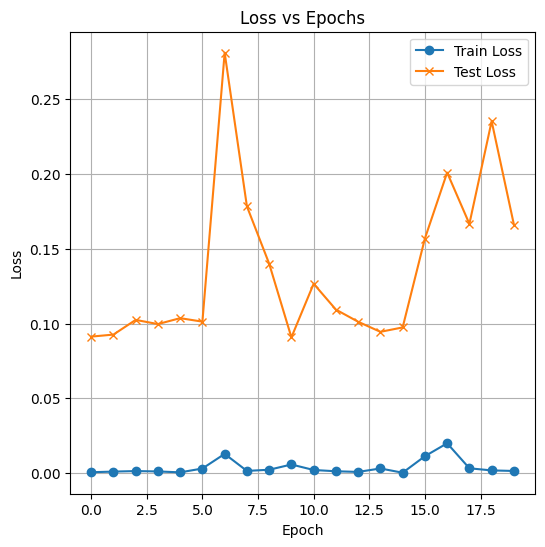

In [ ]:

import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(6,6))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(test_losses, label='Test Loss', marker='x')
plt.title('Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


## 14. Visualize Accuracy Progression

**Generate Accuracy vs Epochs Plot:**

This plot complements the loss visualization by showing accuracy improvements.

**Two lines are plotted:**
1. **Training Accuracy (Blue)**: Performance on training data
   - Should increase and plateau near 100%
   - Shows how well model fits training data

2. **Test Accuracy (Orange)**: Performance on unseen test data
   - More important metric for real-world performance
   - Should remain close to training accuracy

**Analysis:**
- ✓ Both lines increasing together: Effective learning
- ✓ Test accuracy ~98%: Excellent performance
- ✓ Small gap (1-2%): Minimal overfitting
- ✗ Large gap (>5%): Model overfitting

**Final Result**: ~100% training accuracy, ~98% test accuracy indicates a well-trained model with excellent generalization!

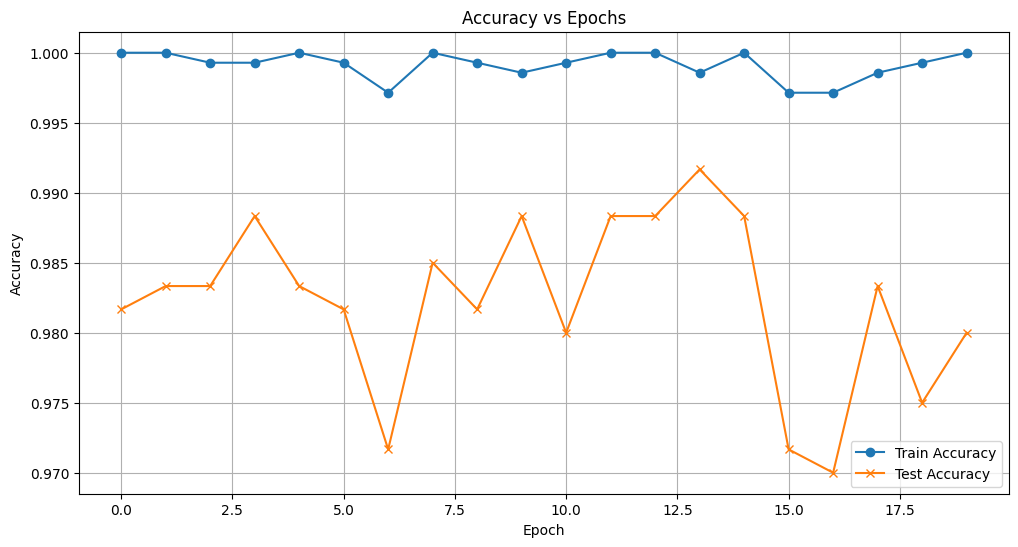

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(test_accuracies, label='Test Accuracy', marker='x')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## 15. Display Sample Predictions with Images

**Visual Verification of Model Performance:**

This cell displays actual images from the test set along with the model's predictions.

**What you'll see:**
- Grid of sample concrete/pavement images
- True label for each image (Cracked/Not Cracked)
- Model's predicted label
- Visual confirmation that the model is working correctly

**Benefits:**
- Intuitive understanding of model performance
- Identify types of images the model handles well
- Spot any systematic errors or misclassifications
- Build confidence in the model's practical applicability

**Note**: This qualitative assessment complements the quantitative metrics (accuracy, loss) calculated earlier.

Most predictions should be correct given the ~98% test accuracy!

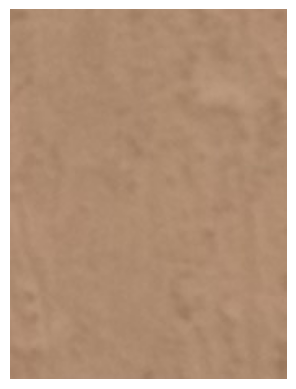

100.00% Confidence this is 'No Crack'


In [ ]:
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

# --- Function to map output to label ---
def label_name(number):
    if number == 0:
        return 'No Crack'
    else:
        return 'Crack'

# --- Load and preprocess the image ---
img_path = r"/content/drive/My Drive/ML_PROJECT/Negative_Analysis/00072.jpg"  # replace with your image path
img = Image.open(img_path).convert('RGB')

# Transform to match training data
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
x = transform(img).unsqueeze(0)  # add batch dimension
x = x.to(device)  # send to GPU if available

# --- Model prediction ---
model.eval()
with torch.no_grad():
    outputs = model(x)
    probs = torch.softmax(outputs, dim=1)
    predicted_class = torch.argmax(probs, dim=1).item()
    confidence = probs[0, predicted_class].item() * 100

# --- Display image and result ---
plt.imshow(img)
plt.axis('off')
plt.show()

print(f"{confidence:.2f}% Confidence this is '{label_name(predicted_class)}'")


In [ ]:
# Save only the trained weights
torch.save(model.state_dict(), "/content/drive/My Drive/ML_PROJECT/best_model.pth")
